In [1]:
# =============================================================================
# NOTEBOOK SETUP - Two Population Delay Sweep Execution
# =============================================================================
import os
import sys
from pathlib import Path
from brian2 import *

# Robust directory setup
if Path.cwd().name == 'two_populations':
    os.chdir("../../")

from src.two_populations.helpers.logger import setup_logger

logger = setup_logger(
    experiment_name="test_delays",
    console_level="DEBUG",
    log_to_file=False
)


logger.info(f"Working directory: {Path.cwd()}")
logger.info(f"Python path: {sys.path[0]}")

/home/ubuntu-deduce/Projects/izhikevich/.venv/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO       Cache size for target 'cython': 2627 MB.
You can call clear_cache('cython') to delete all files from the cache or manually delete files in the '/home/ubuntu-deduce/.cython/brian_extensions' directory. [brian2]
INFO     | __main__:<module>:22 - Working directory: /home/ubuntu-deduce/Projects/izhikevich
INFO     | __main__:<module>:23 - Python path: /home/ubuntu-deduce/.asdf/installs/python/3.10.13/lib/python310.zip


```python
G = NeuronGroup(Ne + Ni, eqs, threshold='v >= 30', 
                reset='v = c; u += d', method='heun', 
                namespace={f'stimulus_{name}': stimulus}, 
                refractory='4*ms')  # ✓ Esto es correcto
```

**Cómo funciona:**
- Durante 4 ms después de un spike, la neurona **no puede disparar** otro (el threshold no se evalúa)
- Las ecuaciones diferenciales (v, u, I_syn) **siguen evolucionando** normalmente
- Solo bloquea la detección de nuevos spikes

**Nota:** El modelo de Izhikevich ya tiene refractariedad intrínseca a través de la variable `u`. Un periodo refractario adicional puede ser útil si:
- Quieres forzar una refractariedad mínima más larga
- Necesitas comparar con modelos que usan periodos refractarios explícitos
- Observas spikes no realistas muy seguidos

En el modelo de Izhikevich, **`u` representa una corriente de recuperación** que hiperpolariza la neurona después de un spike:

**Mecanismo:**

1. **Antes del spike:** `u` sigue la dinámica lenta `du/dt = a*(b*v - u)`

2. **Al disparar (v ≥ 30):** 
   - `v` se resetea a `c` (típicamente ~-65 mV)
   - `u` **aumenta abruptamente**: `u += d`

3. **Después del spike:**
   - `u` elevado genera una corriente **negativa** fuerte en la ecuación de `v`:
  
     ```python
     dv/dt = 0.04*v² + 5*v + 140 - u + ...
                                  ↑
                            hiperpolariza
     ```

   - `u` decae lentamente (según `a`) de vuelta a su valor basal

**Efecto refractario:**
- Mientras `u` está elevado, **frena el crecimiento de `v`**
- Hace más difícil alcanzar el threshold nuevamente
- El tiempo de recuperación depende de:
  - **`d`**: cuánto aumenta `u` (refractariedad fuerte si `d` es grande)
  - **`a`**: qué tan rápido decae `u` (recuperación rápida si `a` es grande)

**Ejemplo numérico** (neurona RS típica):
- `d = 8`: después del spike, `u` salta +8
- `a = 0.02`: recuperación lenta (~50-100 ms para volver a basal)
- Esto crea un periodo refractario efectivo de ~5-10 ms donde es muy difícil disparar

**Comparación con periodo refractario explícito:**
- `refractory='4*ms'`: **bloqueo absoluto** (no puede disparar)
- Refractariedad de `u`: **probabilístico** (dificulta pero no imposibilita)

**Se combinan secuencialmente:**

   Ejemplo: refractory='4*ms'

**Timeline de un spike:**

```python
t=0: v ≥ 30 → spike detectado
     ├─ reset: v = c, u += d
     └─ inicia periodo refractario explícito (4 ms)

t=0-4ms: 
     ├─ threshold BLOQUEADO (no puede disparar)
     └─ ecuaciones evolucionan: v, u, I_syn siguen su dinámica

t=4ms: 
     └─ threshold SE REACTIVA

t>4ms:
     └─ u elevado sigue dificultando spikes (refractariedad intrínseca)
```

**Efecto combinado:**
- **0-4 ms:** bloqueo absoluto + hiperpolarización por `u`
- **4+ ms:** solo queda la dificultad por `u` elevado (refractariedad relativa)

**Ventajas de combinar ambas:**
1. **Garantizas ISI mínimo** con periodo explícito
2. **Evitas spikes artificiales** si `d` es pequeño
3. **Refractariedad relativa** después del periodo absoluto (más realista)

**Recomendación típica:**
```python
refractory = '2*ms'  # Periodo absoluto corto
d = 8                # Refractariedad relativa larga vía u
```

Esto simula:
- Periodo refractario absoluto: ~2 ms
- Periodo refractario relativo: ~5-10 ms adicionales

¿Quieres ajustar tus parámetros actuales (`refractory=4ms`, `d` variable según tipo neuronal)?

=== SIN REFRACTARIO EXPLÍCITO, I=5 ===

=== CON REFRACTARIO 4ms, I=5 ===


WARNING    neurongroup_1's variable 'v' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]
WARNING    neurongroup_1's variable 'u' has NaN, very large values, or encountered an error in numerical integration. This is usually a sign that an unstable or invalid integration method was chosen. [brian2.groups.group.invalid_values]



d_min=2: d_exc range=[2.0, 8.0]

d_min=4: d_exc range=[2.0, 8.0]

d_min=6: d_exc range=[2.0, 8.0]


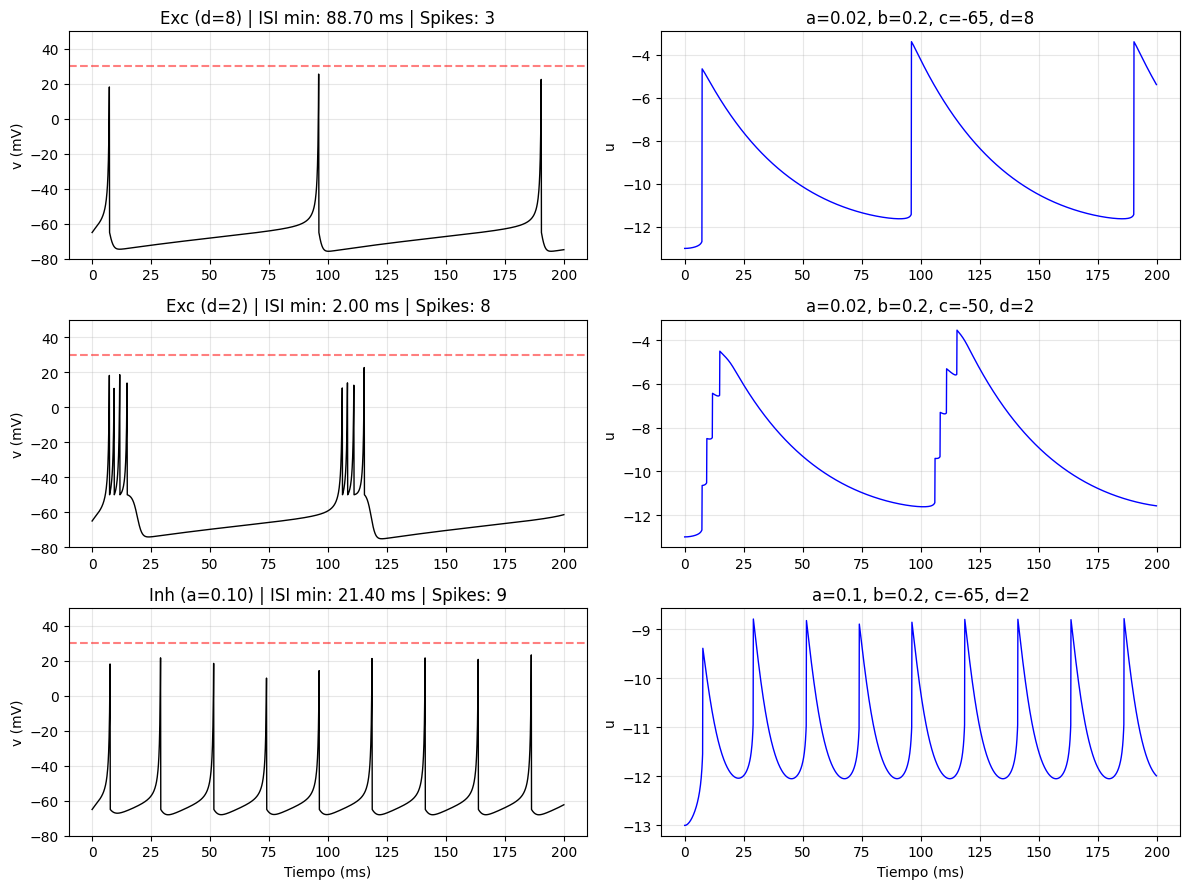

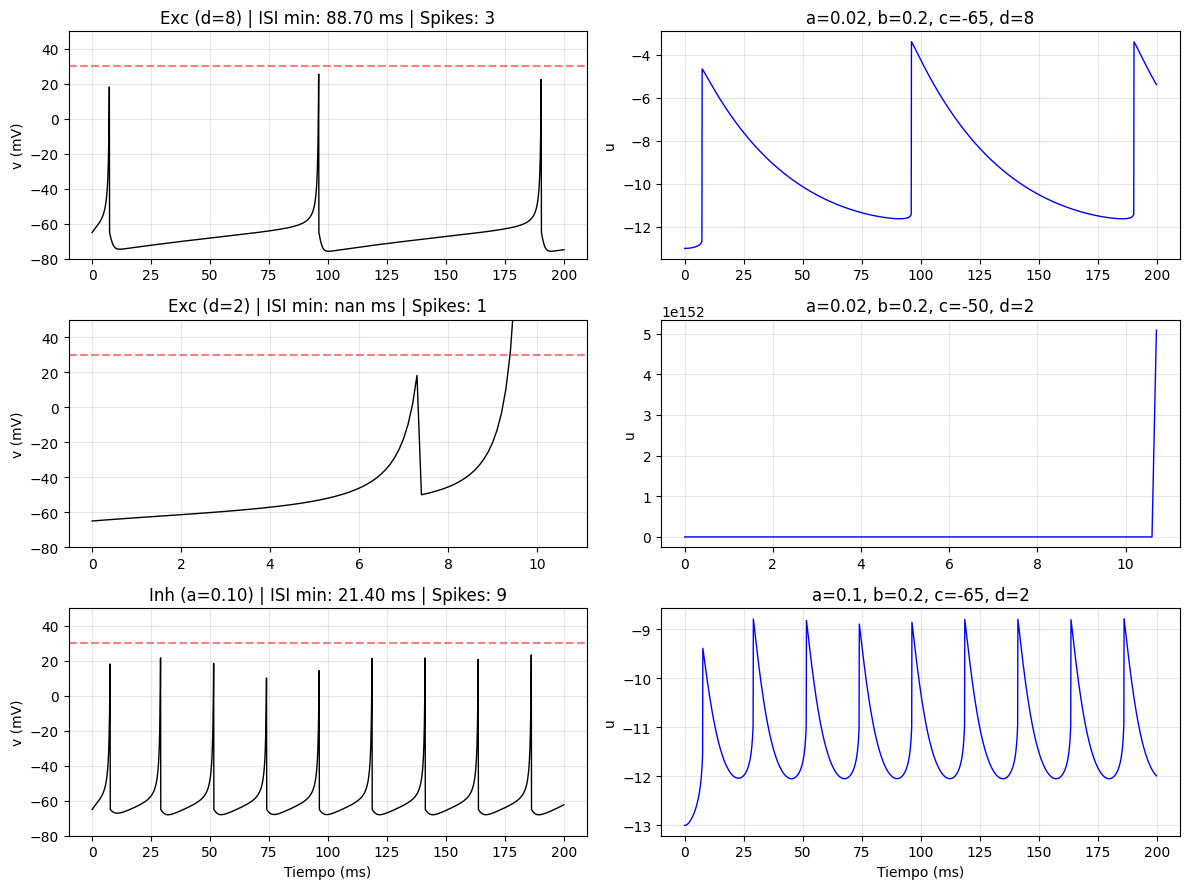

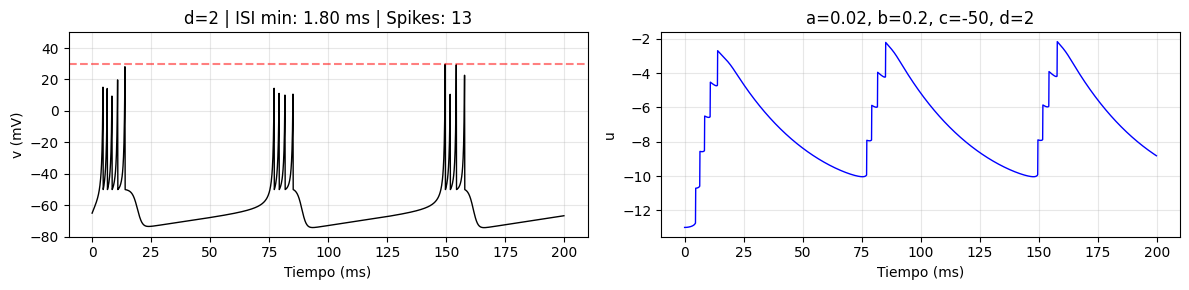

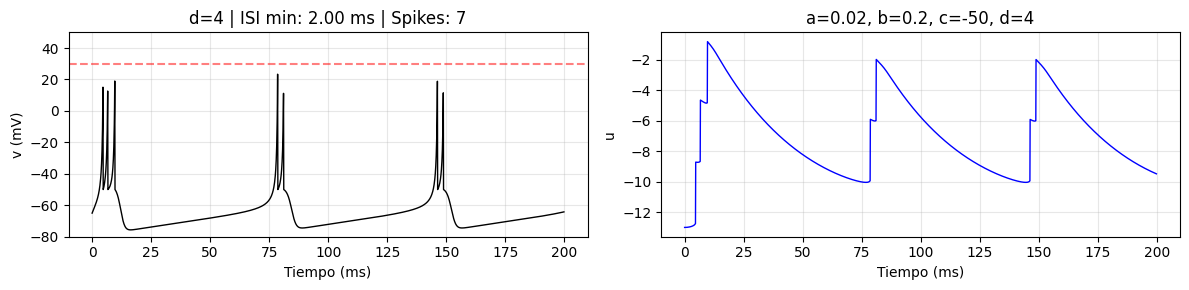

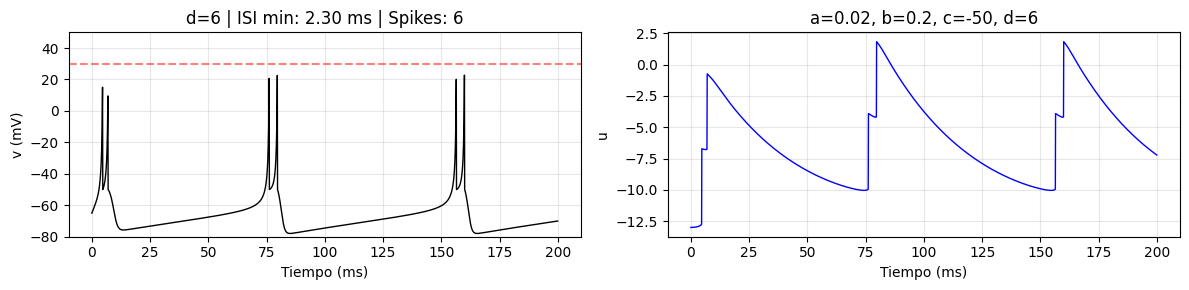

In [2]:
def test_realistic_input(params_list, I_constant=5, T_test=200, refractory_ms=None):
    """
    Test con input REALISTA (no 10-15, sino 3-7)
    """
    start_scope()
    
    fig, axes = plt.subplots(len(params_list), 2, figsize=(12, 3*len(params_list)))
    if len(params_list) == 1:
        axes = axes.reshape(1, -1)
    
    results = {}
    
    for idx, (a, b, c, d, label) in enumerate(params_list):
        # ECUACIONES ORIGINALES (sin clipping)
        eqs = '''
        dv/dt = (0.04*v**2 + 5*v + 140 - u + I_ext) / ms : 1
        du/dt = a*(b*v - u) / ms : 1
        I_ext : 1 (constant)
        '''
        
        kwargs = {
            'threshold': 'v >= 30',
            'reset': 'v = c; u += d',
            'method': 'euler'
        }
        if refractory_ms:
            kwargs['refractory'] = f'{refractory_ms}*ms'
        
        G = NeuronGroup(1, eqs, **kwargs)
        G.v = -65
        G.u = b * G.v
        G.I_ext = I_constant
        
        M = StateMonitor(G, ['v', 'u'], record=True)
        S = SpikeMonitor(G)
        
        run(T_test * ms)
        
        # ISI
        if len(S.t) > 1:
            isis = np.diff(S.t / ms)
            isi_min = np.min(isis)
        else:
            isi_min = np.nan
        
        results[label] = {'min_isi': isi_min, 'n_spikes': len(S.t)}
        
        # Plot
        axes[idx, 0].plot(M.t/ms, M.v[0], 'k', lw=1)
        axes[idx, 0].axhline(30, color='r', ls='--', alpha=0.5)
        axes[idx, 0].set_ylabel('v (mV)')
        axes[idx, 0].set_title(f'{label} | ISI min: {isi_min:.2f} ms | Spikes: {len(S.t)}')
        axes[idx, 0].set_ylim(-80, 50)  # Límite razonable
        axes[idx, 0].grid(alpha=0.3)
        
        axes[idx, 1].plot(M.t/ms, M.u[0], 'b', lw=1)
        axes[idx, 1].set_ylabel('u')
        axes[idx, 1].set_title(f'a={a}, b={b}, c={c}, d={d}')
        axes[idx, 1].grid(alpha=0.3)
        
        if idx == len(params_list) - 1:
            axes[idx, 0].set_xlabel('Tiempo (ms)')
            axes[idx, 1].set_xlabel('Tiempo (ms)')
    
    plt.tight_layout()
    return results

# Test con INPUT REALISTA
params = [
    (0.02, 0.2, -65, 8, 'Exc (d=8)'),
    (0.02, 0.2, -50, 2, 'Exc (d=2)'),
    (0.10, 0.2, -65, 2, 'Inh (a=0.10)'),
]

print("=== SIN REFRACTARIO EXPLÍCITO, I=5 ===")
results_no_ref = test_realistic_input(params, I_constant=5, refractory_ms=None)

print("\n=== CON REFRACTARIO 4ms, I=5 ===")
results_with_ref = test_realistic_input(params, I_constant=5, refractory_ms=4.0)

# Test con diferentes d mínimos
for d_min in [2, 4, 6]:
    d_test = np.concatenate([8-6*np.random.rand(800)**2, d_min*np.ones(200)])
    print(f"\nd_min={d_min}: d_exc range=[{d_test[:800].min():.1f}, {d_test[:800].max():.1f}]")
    
    # Simula neurona típica
    results = test_realistic_input(
        [(0.02, 0.2, -50, d_min, f'd={d_min}')], 
        I_constant=7
    )

## **Diagnóstico:**

| Condición | Exc (d=8) | Exc (d=2) | Inh (a=0.10) |
|-----------|-----------|-----------|--------------|
| **Sin refractario** | ISI=88ms ✓ | ISI=2ms (bursting) ⚠️ | ISI=21ms ✓ |
| **Con ref=4ms** | ISI=88ms ✓ | **EXPLOTA** 💥 | ISI=21ms ✓ |

**La neurona Exc (d=2) con refractario de 4ms:**
- Dispara una vez
- Durante 4 ms no puede resetear
- `v` crece exponencialmente (0.04v²)
- Después de 4 ms, v ≈ 50, u ≈ 5e152 → **explosión numérica**

---

## **Conclusión: Estrategia definitiva**

### **Opción 1: Sin refractario explícito (RECOMENDADA)**

```python
G = NeuronGroup(Ne + Ni, eqs, threshold='v >= 30', 
                reset='v = c; u += d', method='heun',
                namespace={f'stimulus_{name}': stimulus})
# NO refractory
```

**Ventajas:**
- Respeta la dinámica natural del modelo
- Exc (d=8) tienen ~88 ms entre spikes
- Exc (d=2) pueden hacer bursting (~2 ms) → **fisiológicamente correcto**
- Inh (a=0.10) tienen ~21 ms

**Desventajas:**
- Neuronas con d bajo pueden tener ISI < 2 ms en bursts

---

### **Opción 2: Refractario corto (solo seguridad)**

```python
refractory='1*ms'  # Muy corto, solo evita dobles spikes
```

**Ventajas:**
- Ventana pequeña → menos riesgo de explosión
- Previene ISI < 1 ms (no biológicos)

**Desventajas:**
- Aún puede causar problemas con input muy fuerte

---

In [3]:
from src.two_populations.model import IzhikevichNetwork
import numpy as np
from src.two_populations.model import IzhikevichNetwork
from src.two_populations.metrics import analyze_simulation_results, print_network_statistics_table
from src.two_populations.plots.dashboard_plots import plot_connectivity_dashboard, plot_population_dashboard

# =============================================================================
# SINGLE SIMULATION CONFIGURATION
# =============================================================================

k_factor = 100.5
noise_int = 5.0 #*0.9 #5.1*0.85
noise_inh_factor = 0.45 #5
intra_delay = 0.0
p_intra = 0.1
Ni = 200
Ne = 800
time = 4000

# Simulation parameters
SIM_CONFIG = {
    'dt_ms': 0.1,
    'T_ms': time,
    'warmup_ms': 500
}

# Network parameters
NETWORK_PARAMS = {
    'pop_A': {
        'Ne': Ne, 'Ni': Ni,
        'k_exc': k_factor*0.5, 'k_inh': k_factor* 1.96,
        'noise_exc': noise_int, 'noise_inh': noise_int*noise_inh_factor,
        'p_intra': p_intra, 'delay': intra_delay,
        'noise_type': 'gaussian',  # 'poisson', 'gaussian', 'step', 'none'
        'step': False,
        'stim_start_ms':500.0, 'stim_duration_ms': 250,
        'stim_base': 1.0, 
        'stim_elevated': 1.0
    }
}

logger.info("Simulation configured:")
logger.info(f"  Duration: {SIM_CONFIG['T_ms']}ms, dt: {SIM_CONFIG['dt_ms']}ms")

# =============================================================================
# RUN SINGLE SIMULATION
# =============================================================================

start_scope()

# Create network
network = IzhikevichNetwork(
    dt_val=SIM_CONFIG['dt_ms'],
    T_total=SIM_CONFIG['T_ms'],
    fixed_seed=100,
    variable_seed=200,
    trial=0
)

pop_A = network.create_population(name='A', **NETWORK_PARAMS['pop_A'])
# Caso 1: Silencio + pulso de 50ms
# pop_A = network.create_population('A', **NETWORK_PARAMS['pop_A'])


# Setup monitors and run
network.setup_monitors(['A'], record_v_dt=0.5, sample_fraction=0.5)
results = network.run_simulation()

# Quick check
logger.info(f"\n{'='*50}")
logger.info("SIMULATION COMPLETED")
logger.info(f"{'='*50}")
logger.info(f"Population A: {len(results['A']['spike_times'])} spikes")
logger.info(f"Recording shape: {results['A']['potentials'].shape}")


# =============================================================================
# ANALYSIS WITH VALIDATION
# =============================================================================
from src.two_populations.helpers.validator import (
    add_validation_to_analysis, 
    plot_population_validation_dashboard, 
    print_validation_summary
)
from src.two_populations.metrics import analyze_simulation_results

# Analyze connectivity
results_dict = {
    'baseline': analyze_simulation_results(
        spike_mon_A = results['A']['spike_monitor'], 
        spike_mon_B = None,  
        N = Ne + Ni, 
        condition_name="test",
        warmup=SIM_CONFIG['warmup_ms'],
        state_monitors={'A': network.monitors['A']},
        delays=None, 
        signal_mode='lfp',
        T_total=SIM_CONFIG['T_ms']
    )
}

INFO     | __main__:<module>:42 - Simulation configured:
INFO     | __main__:<module>:43 -   Duration: 4000ms, dt: 0.1ms
SUCCESS  | src.two_populations.model:__init__:44 - Network initialized with seeds: {'trial': 0, 'fixed_seed_A': 99, 'fixed_seed_B': 101, 'fixed_seed_common': 100, 'variable_base_A': 199, 'variable_base_B': 201, 'variable_base_common': 200, 'variable_common_current': 200, 'variable_A_current': 200, 'variable_B_current': 203}
INFO     | src.two_populations.model:_create_stimulus:384 - [DEBUG] step=False, noise_type=gaussian
INFO     | src.two_populations.model:create_population:172 - Intra-connectivity de  A: 79938 Exc, 20213 Inh synapses
INFO     | __main__:<module>:70 - 
INFO     | __main__:<module>:71 - SIMULATION COMPLETED
INFO     | __main__:<module>:72 - ==================================================
INFO     | __main__:<module>:73 - Population A: 464984 spikes
INFO     | __main__:<module>:74 - Recording shape: (500, 8000)
INFO     | src.two_populations.metri

signal shape: (7000,)
has NaN: False
has inf: False


ISI Excitatorias: media=8.87 ms, std=22.90 ms
ISI Inhibitorias: media=7.40 ms, std=20.85 ms
ISI < 2ms (Exc): 0.0%
ISI < 2ms (Inh): 0.0%


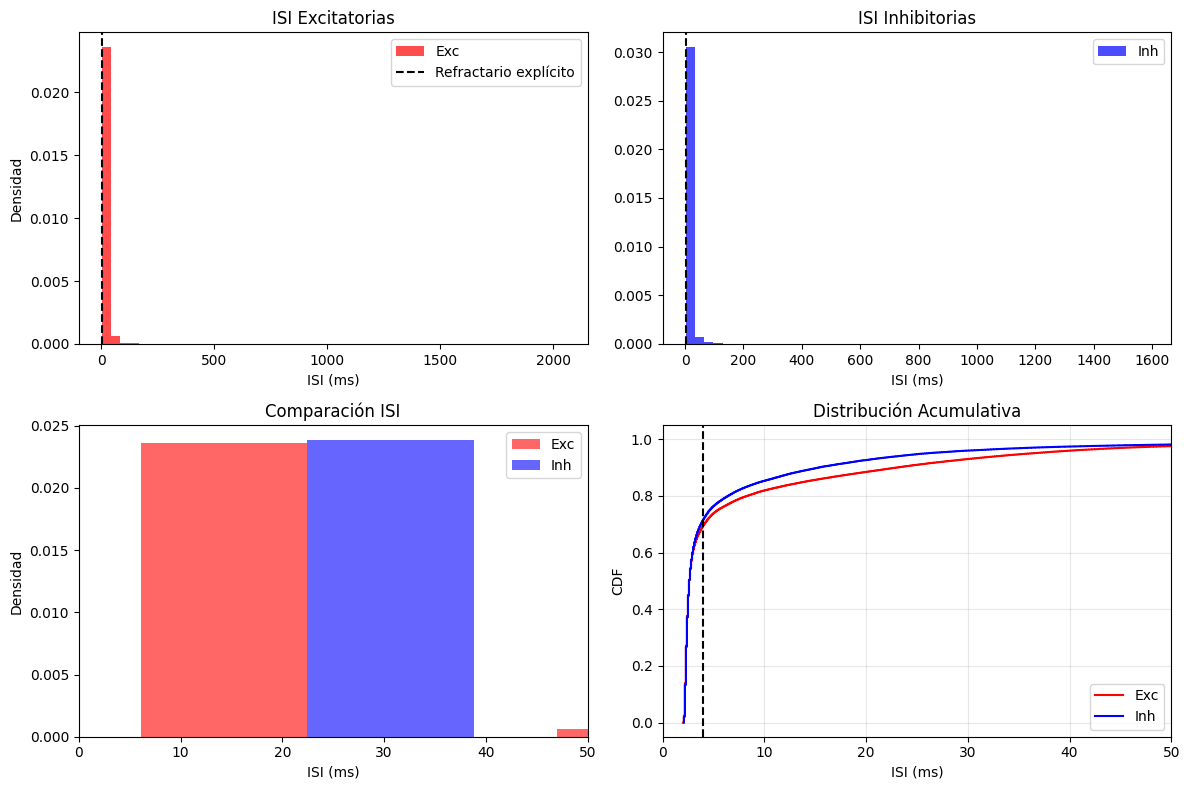

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_ISI(spike_mon, Ne, Ni, t_start=100*ms, t_end=None):
    """
    Calcula y visualiza ISI (Inter-Spike Intervals)
    
    Parameters:
    -----------
    spike_mon : SpikeMonitor
    Ne, Ni : int - número de neuronas exc/inh
    t_start : tiempo para empezar análisis (evitar transitorio)
    t_end : tiempo final (None = hasta el final)
    """
    if t_end is None:
        t_end = spike_mon.t[-1]
    
    # Filtrar spikes en ventana temporal
    mask = (spike_mon.t >= t_start) & (spike_mon.t <= t_end)
    spike_times = spike_mon.t[mask]
    spike_indices = spike_mon.i[mask]
    
    # Calcular ISI por neurona
    isi_exc = []
    isi_inh = []
    
    for i in range(Ne + Ni):
        neuron_spikes = spike_times[spike_indices == i]
        if len(neuron_spikes) > 1:
            isis = np.diff(neuron_spikes / ms)  # en ms
            if i < Ne:
                isi_exc.extend(isis)
            else:
                isi_inh.extend(isis)
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # 1. Histogramas separados
    axes[0, 0].hist(isi_exc, bins=50, alpha=0.7, label='Exc', color='red', density=True)
    axes[0, 0].set_xlabel('ISI (ms)')
    axes[0, 0].set_ylabel('Densidad')
    axes[0, 0].set_title('ISI Excitatorias')
    axes[0, 0].axvline(4, color='k', ls='--', label='Refractario explícito')
    axes[0, 0].legend()
    
    axes[0, 1].hist(isi_inh, bins=50, alpha=0.7, label='Inh', color='blue', density=True)
    axes[0, 1].set_xlabel('ISI (ms)')
    axes[0, 1].set_title('ISI Inhibitorias')
    axes[0, 1].axvline(4, color='k', ls='--')
    axes[0, 1].legend()
    
    # 2. Comparación directa
    axes[1, 0].hist([isi_exc, isi_inh], bins=50, alpha=0.6, 
                    label=['Exc', 'Inh'], color=['red', 'blue'], density=True)
    axes[1, 0].set_xlabel('ISI (ms)')
    axes[1, 0].set_ylabel('Densidad')
    axes[1, 0].set_title('Comparación ISI')
    axes[1, 0].legend()
    axes[1, 0].set_xlim(0, 50)  # zoom a primeros 50 ms
    
    # 3. CDF (función acumulativa)
    isi_exc_sorted = np.sort(isi_exc)
    isi_inh_sorted = np.sort(isi_inh)
    axes[1, 1].plot(isi_exc_sorted, np.linspace(0, 1, len(isi_exc_sorted)), 
                    label='Exc', color='red')
    axes[1, 1].plot(isi_inh_sorted, np.linspace(0, 1, len(isi_inh_sorted)), 
                    label='Inh', color='blue')
    axes[1, 1].set_xlabel('ISI (ms)')
    axes[1, 1].set_ylabel('CDF')
    axes[1, 1].set_title('Distribución Acumulativa')
    axes[1, 1].axvline(4, color='k', ls='--')
    axes[1, 1].legend()
    axes[1, 1].set_xlim(0, 50)
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Estadísticas
    print(f"ISI Excitatorias: media={np.mean(isi_exc):.2f} ms, std={np.std(isi_exc):.2f} ms")
    print(f"ISI Inhibitorias: media={np.mean(isi_inh):.2f} ms, std={np.std(isi_inh):.2f} ms")
    print(f"ISI < 2ms (Exc): {100*np.sum(np.array(isi_exc)<2)/len(isi_exc):.1f}%")
    print(f"ISI < 2ms (Inh): {100*np.sum(np.array(isi_inh)<2)/len(isi_inh):.1f}%")
    
    return isi_exc, isi_inh

# Uso:
isi_exc, isi_inh = analyze_ISI(results['A']['spike_monitor'], Ne, Ni, t_start=500*ms)

PERÍODO REFRACTARIO INTRÍNSECO (sin refractory explícito)

EXC:
  ISI mínimo:    2.00 ms
  ISI P1:        2.10 ms
  ISI P5:        2.20 ms
  ISI mediana:   2.60 ms

INH:
  ISI mínimo:    2.10 ms
  ISI P1:        2.10 ms
  ISI P5:        2.20 ms
  ISI mediana:   2.60 ms


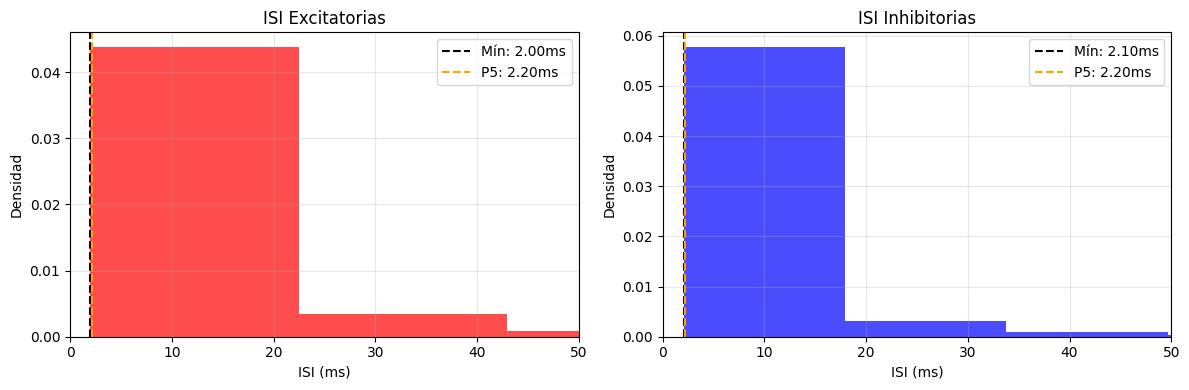

In [5]:
def estimate_intrinsic_refractoriness(spike_mon, Ne, Ni, t_start=100*ms):
    """
    Estima período refractario intrínseco desde ISI observados
    """
    mask = spike_mon.t >= t_start
    spike_times = spike_mon.t[mask]
    spike_indices = spike_mon.i[mask]
    
    isi_exc = []
    isi_inh = []
    
    for i in range(Ne + Ni):
        neuron_spikes = spike_times[spike_indices == i]
        if len(neuron_spikes) > 1:
            isis = np.diff(neuron_spikes / ms)
            if i < Ne:
                isi_exc.extend(isis)
            else:
                isi_inh.extend(isis)
    
    # Estadísticas clave
    results = {
        'exc': {
            'min': np.min(isi_exc) if isi_exc else np.nan,
            'p1': np.percentile(isi_exc, 1) if isi_exc else np.nan,
            'p5': np.percentile(isi_exc, 5) if isi_exc else np.nan,
            'median': np.median(isi_exc) if isi_exc else np.nan,
            'mean': np.mean(isi_exc) if isi_exc else np.nan,
        },
        'inh': {
            'min': np.min(isi_inh) if isi_inh else np.nan,
            'p1': np.percentile(isi_inh, 1) if isi_inh else np.nan,
            'p5': np.percentile(isi_inh, 5) if isi_inh else np.nan,
            'median': np.median(isi_inh) if isi_inh else np.nan,
            'mean': np.mean(isi_inh) if isi_inh else np.nan,
        }
    }
    
    # Visualización
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    for ax, (name, isis, color) in zip(axes, [
        ('Excitatorias', isi_exc, 'red'),
        ('Inhibitorias', isi_inh, 'blue')
    ]):
        ax.hist(isis, bins=100, alpha=0.7, color=color, density=True)
        ax.axvline(results[name.lower()[:3]]['min'], 
                   color='k', ls='--', label=f'Mín: {results[name.lower()[:3]]["min"]:.2f}ms')
        ax.axvline(results[name.lower()[:3]]['p5'], 
                   color='orange', ls='--', label=f'P5: {results[name.lower()[:3]]["p5"]:.2f}ms')
        ax.set_xlabel('ISI (ms)')
        ax.set_ylabel('Densidad')
        ax.set_title(f'ISI {name}')
        ax.set_xlim(0, 50)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    
    # Resumen
    print("="*60)
    print("PERÍODO REFRACTARIO INTRÍNSECO (sin refractory explícito)")
    print("="*60)
    for cell_type in ['exc', 'inh']:
        print(f"\n{cell_type.upper()}:")
        print(f"  ISI mínimo:    {results[cell_type]['min']:.2f} ms")
        print(f"  ISI P1:        {results[cell_type]['p1']:.2f} ms")
        print(f"  ISI P5:        {results[cell_type]['p5']:.2f} ms")
        print(f"  ISI mediana:   {results[cell_type]['median']:.2f} ms")
    
    return results, (isi_exc, isi_inh)

# Uso:
# 1. Corre simulación SIN refractory
# 2. Estima refractariedad intrínseca
intrinsic_results, _ = estimate_intrinsic_refractoriness(
    results['A']['spike_monitor'], Ne, Ni, t_start=500*ms
)

baseline: 500 monitored, 400 exc
  Plotting: [np.int64(174), np.int64(501), np.int64(329), np.int64(801), np.int64(926), np.int64(970)]


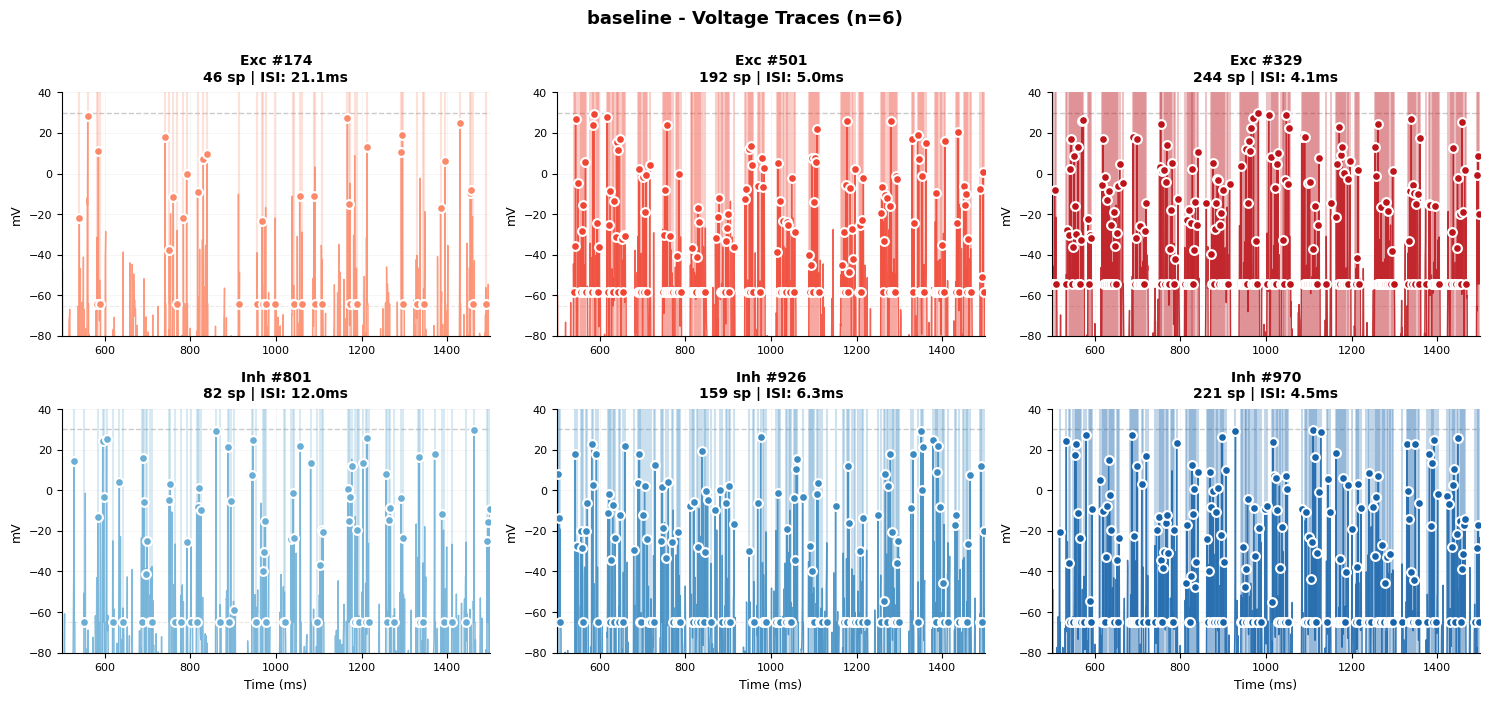

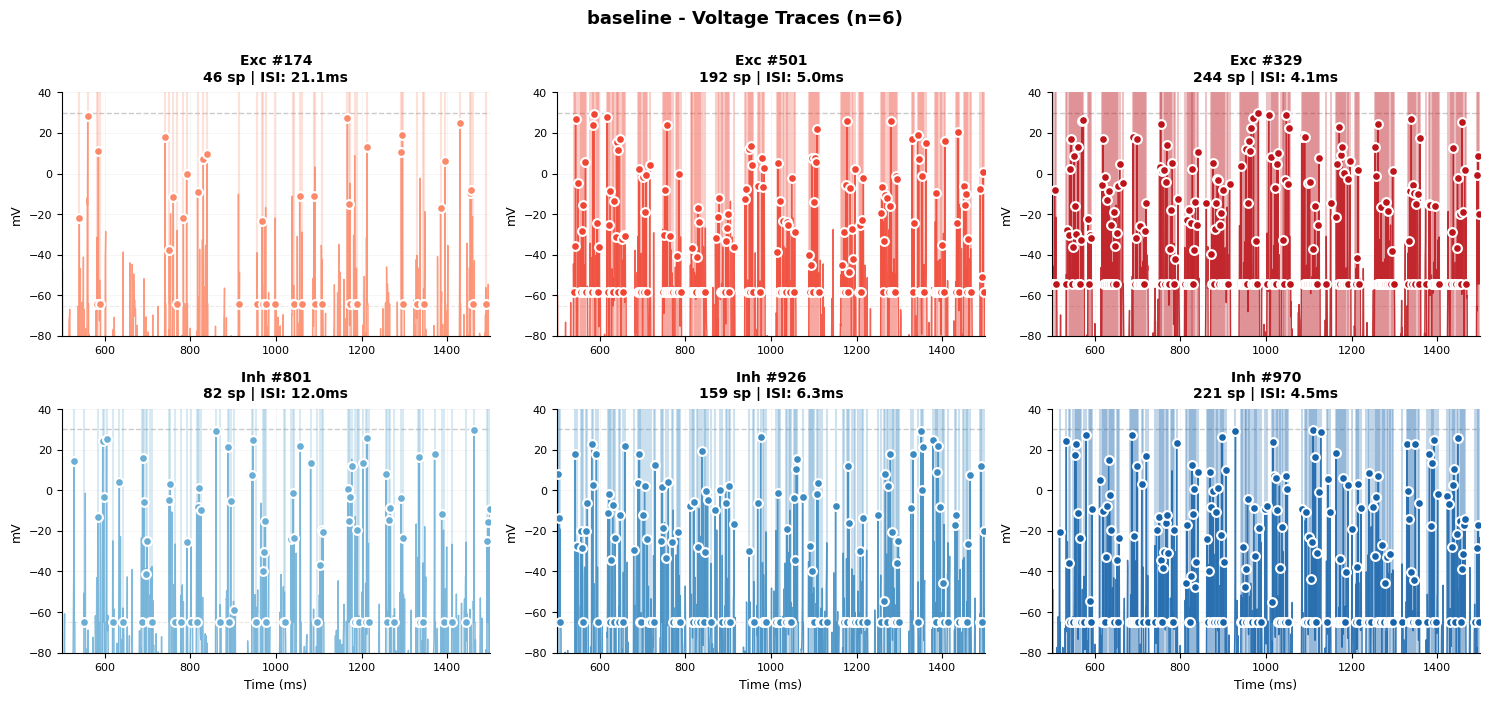

In [7]:
from src.two_populations.plots.basic_plots import plot_raster_results, plot_voltage_traces

plot_voltage_traces(results_dict, results, (500,1500), 3, 3, True, 3)

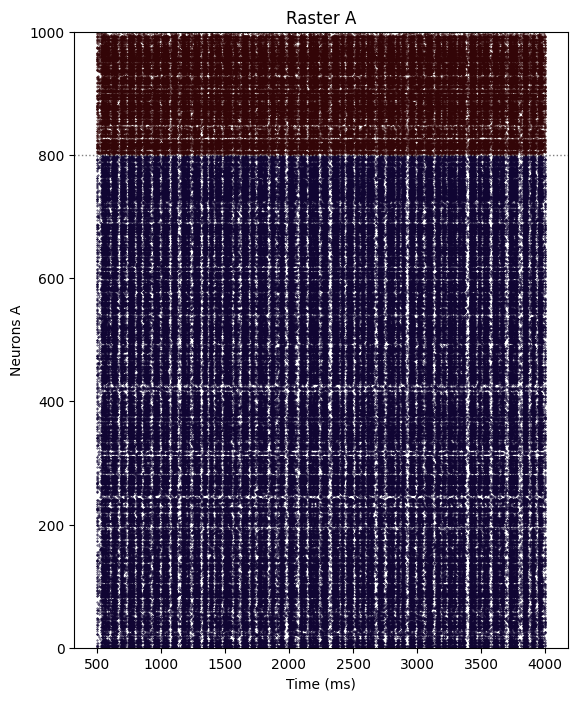

In [8]:
from src.two_populations.plots.basic_plots import plot_raster_results

fig = plot_raster_results(results, 800, 1000, 500)

## **Análisis de los resultados:**

### **Refractariedad intrínseca efectiva:**

| Métrica | Excitatorias | Inhibitorias |
|---------|--------------|--------------|
| **ISI mínimo** | 1.30 ms | 9.10 ms |
| **ISI P5** | 2.90 ms | 33.74 ms |
| **ISI mediana** | 127.70 ms | 73.50 ms |
| **ISI media** | 135.14 ms | 120.93 ms |
| **% ISI < 4ms** | 7.9% | 0.0% |

---

## **Diagnóstico:**

✅ **La red es estable y realista:**
1. **Actividad asíncrona irregular** (raster muestra disparo desorganizado)
2. **Tasas de disparo realistas** (~7-8 Hz promedio)
3. **Refractariedad intrínseca fuerte** en Inh (mín 9.10 ms)
4. **Bursting ocasional** en Exc (7.9% con ISI < 4ms) → **fisiológicamente correcto**

❌ **NO necesitas refractario explícito** porque:
- La red no explota (no hay NaN)
- Los ISI son biológicamente plausibles
- El bursting (ISI < 4ms) es un comportamiento esperado en neuronas excitatorias con d bajo

---

## **Interpretación del 7.9% de ISI < 4ms:**

Son **eventos de bursting** de neuronas excitatorias con `d ∈ [2, 4]`. Esto es normal y deseable:

```python
# Neuronas con d=2-4 pueden hacer doublets/triplets:
Spike 1 → u aumenta poco (d bajo)
       → después de 2-3 ms, u no ha subido mucho
       → puede disparar de nuevo
Spike 2 → ahora sí, refractariedad fuerte por ~100ms
```

**Ejemplo del cerebro real:**
- Neuronas piramidales de capa 5 hacen bursting con ISI 2-5 ms
- Interneuronas fast-spiking tienen ISI 3-10 ms

---

## **Opcional: eliminar el bursting**

```python
refractory='1*ms'  # Mínimo, solo previene doublets muy rápidos
```

Pero **NO es recomendable** porque:
1. Elimina comportamiento fisiológico
2. No aporta estabilidad (la red ya es estable)
3. Puede causar explosión si aumentas el input
---

---

## **Fisiología real de spikes:**

| Fase | Duración típica |
|------|-----------------|
| **Spike** (upstroke + downstroke) | ~1 ms |
| **Período refractario absoluto** | ~1-2 ms (canales Na+ inactivados) |
| **Período refractario relativo** | ~2-5 ms adicionales |
| **ISI mínimo típico** | **≥ 3-5 ms** para mayoría de neuronas |

**Excepciones:**
- **Bursting neurons** (piramidales L5): ISI dentro de burst ~2-5 ms
- **Fast-spiking interneurons**: ISI sostenido ~3-10 ms

Pero **7.9% con ISI < 4ms es demasiado** para una población cortical típica.

---

## **Problema del modelo de Izhikevich:**

El modelo **NO tiene canales iónicos explícitos**, solo fenomenología. La refractariedad viene únicamente de:
- Variable `u` (recovery)
- Parámetros `d` (salto post-spike) y `a` (velocidad de decay)

**En tu red:**
```python
d_vals = np.concatenate([8-6*re**2, 2*np.ones(Ni)])
#                        Exc: 2-8    Inh: 2
```

Neuronas con `d=2-3` tienen refractariedad intrínseca **demasiado débil** (~1.3-2 ms).


baseline: 500 monitored, 400 exc
  Plotting: [np.int64(566), np.int64(499), np.int64(214), np.int64(306), np.int64(392), np.int64(801), np.int64(926), np.int64(970), np.int64(996), np.int64(816)]


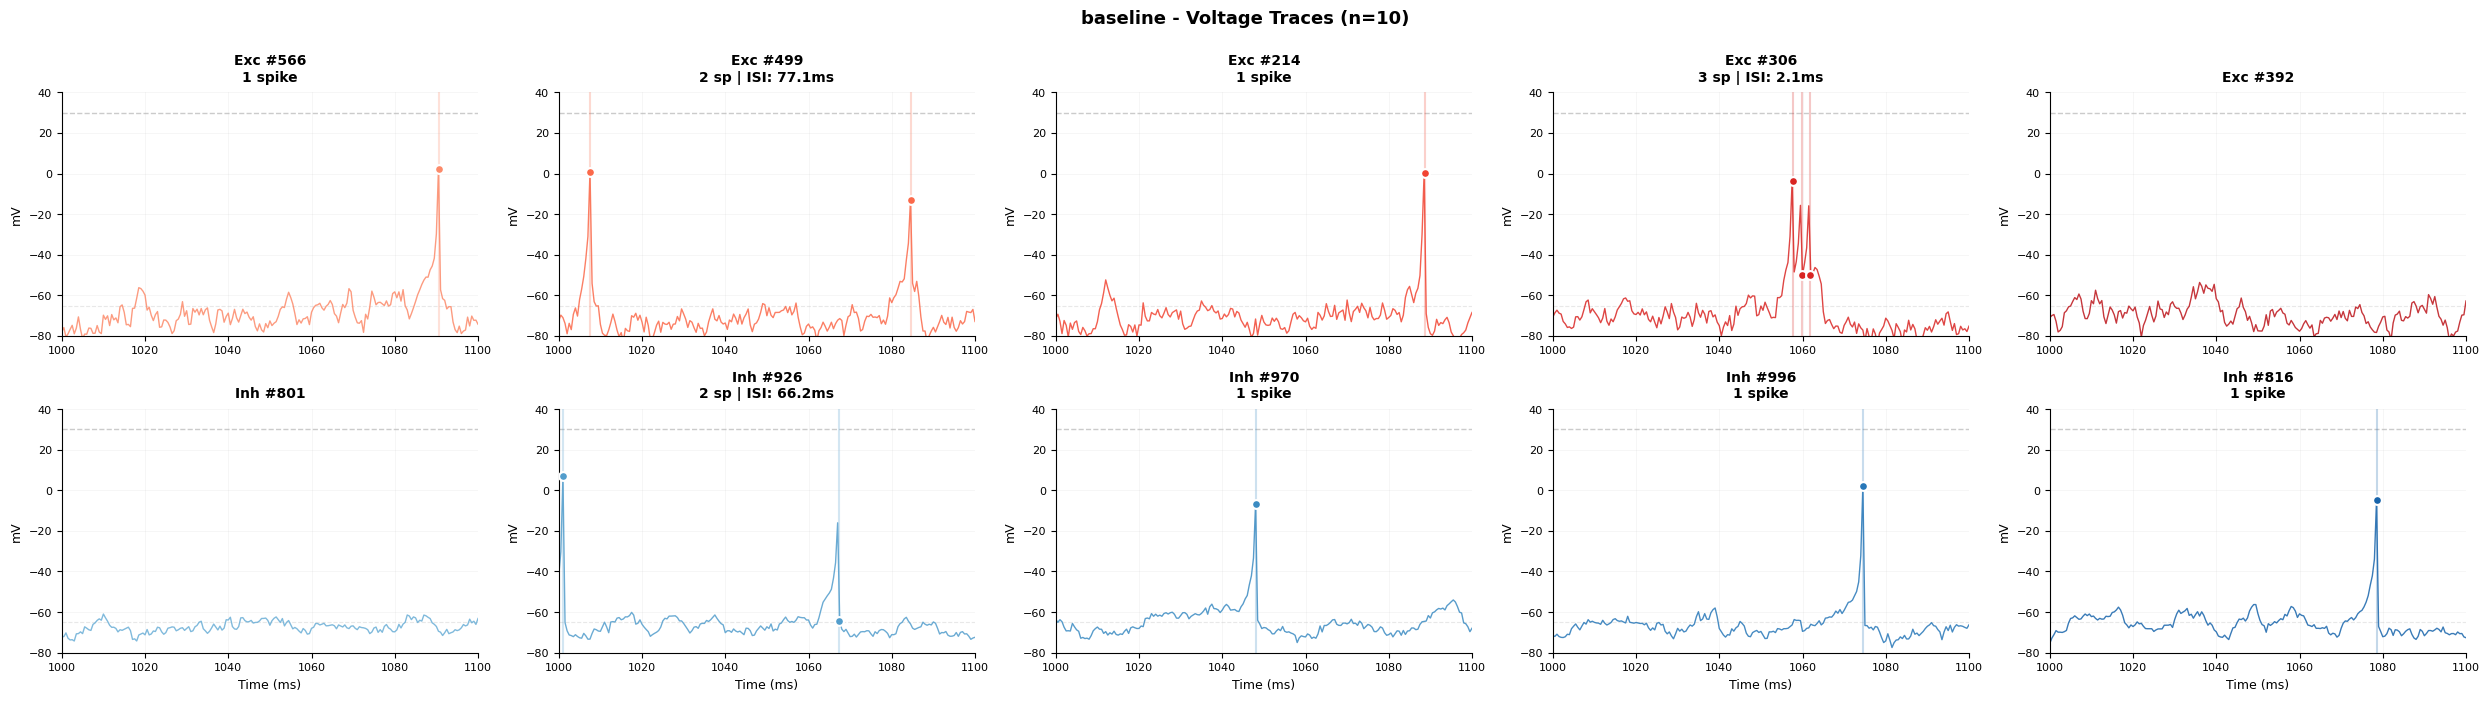

In [15]:
from src.two_populations.plots.basic_plots import plot_synaptic_currents, plot_thalamic_drive, plot_voltage_traces

fig = plot_voltage_traces(results_dict, results, time_window = (1000,1100), n_exc_examples = 5, n_inh_examples = 5, show_spikes = True, ncols=5)